In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
from speculator import Photulator
import fsps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
filters = fsps.find_filter('lsst') + fsps.find_filter('suprimecam')[1:2]+fsps.find_filter('suprimecam')[3:]
print(filters)

['lsst_u',
 'lsst_g',
 'lsst_r',
 'lsst_i',
 'lsst_z',
 'lsst_y',
 'suprimecam_g',
 'suprimecam_r',
 'suprimecam_i',
 'suprimecam_z']

In [4]:
#training data
spsparams = np.load("data/data/training_params.npy")[:1000000]
photometry = np.load("data/data/training_data.npy")[:1000000]
print(spsparams.shape, photometry.shape)

# parameters shift and scale
parameters_shift = np.mean(spsparams, axis=0)
parameters_scale = np.std(spsparams, axis=0)
magnitudes_shift = np.mean(photometry, axis=0)
magnitudes_scale = np.std(photometry, axis=0)

(1000000, 15) (1000000, 10)


In [6]:
# devices
device='cpu'
all_on_device = True
training_theta = torch.from_numpy(spsparams).float().to(device)
training_mag = torch.from_numpy(photometry).float().to(device)

In [7]:
#inputs
n_parameters = spsparams.shape[-1]
n_layers=4
n_units=128

In [8]:
#settings 
verbose = True
filter = 0
optimizer = lambda x: torch.optim.Adam(x, lr=1e-3)
lr=[1e-3, 1e-4, 1e-5, 1e-6]
batch_size=[1000, 10000, 50000, 1000000]
validation_split=0.1
patience=20
maxbatch = 10000
root_dir=''

# put the training data all on the device if we want it there
if all_on_device:
    training_theta = training_theta.to(device)
    training_mag = training_mag.to(device)

# architecture
n_hidden = [n_units]*n_layers

# train one band
f =  filter

if verbose is True:
    print('filter ' + filters[f] + '...')

# construct the PHOTULATOR model
photulator = Photulator(n_parameters=training_theta.shape[-1],
                    filters=[filters[f]],
                    parameters_shift=parameters_shift,
                    parameters_scale=parameters_scale,
                    magnitudes_shift=magnitudes_shift[f],
                    magnitudes_scale=magnitudes_scale[f],
                    n_hidden=[n_units]*n_layers,
                    optimizer=optimizer,
                    device=device)

# train using cooling/heating schedule for lr/batch-size
for i in range(len(lr)):

    if verbose is True:
        print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))

    # set learning rate
    optimizer_state_dict = photulator.optimizer.state_dict()
    optimizer_state_dict['param_groups'][0]['lr'] = lr[i]
    photulator.optimizer.load_state_dict(optimizer_state_dict)

    # dataset and dataloader
    dataset = torch.utils.data.TensorDataset(training_theta, torch.unsqueeze(training_mag[:,f],-1))
    training_data, validation_data = torch.utils.data.random_split(dataset, [int(len(dataset)*(1.-validation_split)), len(dataset) - int(len(dataset)*(1.-validation_split))])
    training_dataloader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=batch_size[i])

    # set up training loss
    training_loss = [np.infty]
    validation_loss = [np.infty]
    best_loss = np.infty
    best_state = photulator.state_dict()
    patience_counter = 0

    # loop over epochs
    while patience_counter < patience:

        # loop over batches for a single epoch
        for theta, mag in training_dataloader:

            # move to correct device
            theta.to(device)
            mag.to(device)

            # training step
            loss = photulator.training_step(theta, mag, maxbatch=maxbatch)

        # compute total loss and validation loss
        validation_theta, validation_mag = validation_data[:]
        validation_loss.append(photulator.compute_loss(validation_theta, validation_mag).cpu().detach().numpy())

        # early stopping condition
        if validation_loss[-1] < best_loss:
            best_loss = validation_loss[-1]
            best_state = photulator.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            photulator.load_state_dict(best_state)
            torch.save(photulator, root_dir + 'model_{}x{}_'.format(n_layers, n_units) + filters[f] + '.pt')
            if verbose is True:
                print('Validation loss = ' + str(best_loss))
            break

# save CPU version of the model by default
photulator.set_device('cpu')
torch.save(photulator, root_dir + 'model_{}x{}_'.format(n_layers, n_units) + filters[f] + '.pt')

filter lsst_u...
learning rate = 0.001, batch size = 1000
Validation loss = 0.20265715
learning rate = 0.0001, batch size = 10000
Validation loss = 0.12367343
learning rate = 1e-05, batch size = 50000
Validation loss = 0.11252295
learning rate = 1e-06, batch size = 1000000
Validation loss = 0.11554267


In [9]:
plt.plot(loss_list)
plt.ylabel('loss (training)')
plt.xlabel('batches')
plt.yscale("log")

NameError: name 'loss_list' is not defined

Text(0.5, 0, 'epoch')

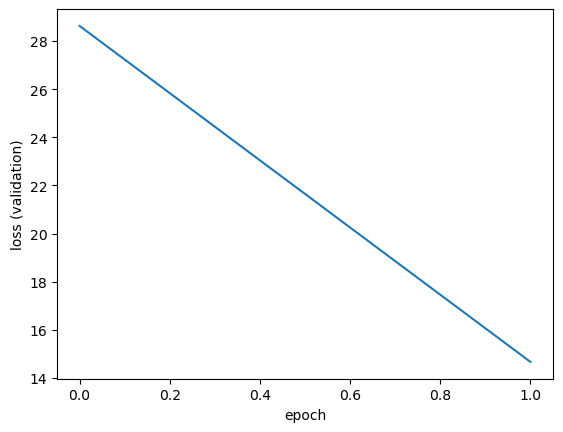

In [ ]:
plt.plot(validation_loss)
plt.ylabel('loss (validation)')
plt.xlabel('epoch')